# Intro to variational quantum algorithm
### Spring 2022 by Hanna Linn

Doing a quantum approximate optimisation algorithm (QAOA) for Minimum vertex cover in Pennylane.

This tutorial is heavily inspired by: https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html

### But first let's do some Pennylane basics!

In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
# Let's make an super easy Hamiltonian

# Qubit registry
qubits = range(4)

# Define coefficients and operators for our Hamiltonian
coeffs = [1.0, 2.0, 3.2]
operators = [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)] # @ is a tensor product in Pennylane

# Make a Hamiltonian, object in Pennylane
H = qml.Hamiltonian(coeffs, operators)
print(H)

  (1.0) [X0]
+ (2.0) [Z1]
+ (3.2) [X0 X1]


In [3]:
# A small circuit

dev = qml.device('default.qubit', wires = qubits)

@qml.qnode(dev) # decorator telling us to use the devide dev for this circuit
def circuit():
    qml.ApproxTimeEvolution(H, 1, 2)
    return [qml.expval(qml.PauliZ(i)) for i in qubits] # measurement of expected value of Pauli Z

print('Hamiltonian with expectation value on the four qubits in Z: ', circuit())
print()

# Draw our circuit
print(qml.draw(circuit, expansion_strategy = 'device')())

Hamiltonian with expectation value on the two qubits in Z:  [-0.41531891  0.9980105   1.          1.        ]

0: ──RX(1.00)─╭RXX(3.20)──RX(1.00)─╭RXX(3.20)─┤  <Z>
1: ──RZ(2.00)─╰RXX(3.20)──RZ(2.00)─╰RXX(3.20)─┤  <Z>
2: ───────────────────────────────────────────┤  <Z>
3: ───────────────────────────────────────────┤  <Z>


### Back to Minimum vertex cover

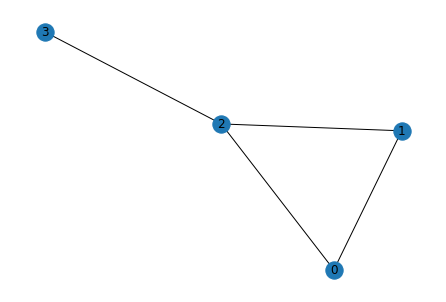

In [4]:
# Making a small graph 

edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [5]:
# Make the Hamiltonians needed for our QAOA

H_cost, _ = qaoa.min_vertex_cover(graph, constrained=False)
H_mixer = qaoa.x_mixer(qubits)

print('H_cost:\n' + str(H_cost))
print()
print('H_mixer:\n' + str(H_mixer))

H_cost:
  (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]

H_mixer:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [6]:
# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, p, params[0], params[1])
    

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)


# Let's test it!
zero_parameters = np.array([[0],[0]])
half_parameters = np.array([[0.5],[0.5]])
p = 1

print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))

# Draw our circuit
print()
print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

Average cost with gamma=0 and beta=0:
 0.0
Average cost with gamma=0.5 and beta=0.5:
 2.062812981571418

0: ──H─╭RZZ(0.00)──RZ(0.00)─╭RZZ(0.00)──RX(0.00)────────────────────────────────────────────┤ ╭<𝓗>
1: ──H─╰RZZ(0.00)──RZ(0.00)─│────────────────────╭RZZ(0.00)──RX(0.00)───────────────────────┤ ├<𝓗>
2: ──H──────────────────────╰RZZ(0.00)──RZ(0.00)─╰RZZ(0.00)─╭RZZ(0.00)──RX(0.00)────────────┤ ├<𝓗>
3: ──H──────────────────────────────────────────────────────╰RZZ(0.00)──RZ(-0.00)──RX(0.00)─┤ ╰<𝓗>


In [7]:
p = 3
half_parameters = np.array([[0.5, 0.5, 0.5],[0.5, 0.5, 0.5]])
print(qml.draw(average_cost, expansion_strategy = 'device')(half_parameters))

0: ──H─╭RZZ(0.75)──RZ(0.50)─╭RZZ(0.75)──RX(1.00)───────────────────────╭RZZ(0.75)──RZ(0.50)
1: ──H─╰RZZ(0.75)──RZ(0.50)─│────────────────────╭RZZ(0.75)──RX(1.00)──╰RZZ(0.75)──RZ(0.50)
2: ──H──────────────────────╰RZZ(0.75)──RZ(1.25)─╰RZZ(0.75)─╭RZZ(0.75)──RX(1.00)───────────
3: ──H──────────────────────────────────────────────────────╰RZZ(0.75)──RZ(-0.25)──RX(1.00)

──╭RZZ(0.75)──RX(1.00)───────────────────────╭RZZ(0.75)──RZ(0.50)─╭RZZ(0.75)──RX(1.00)───────────
──│────────────────────╭RZZ(0.75)──RX(1.00)──╰RZZ(0.75)──RZ(0.50)─│────────────────────╭RZZ(0.75)
──╰RZZ(0.75)──RZ(1.25)─╰RZZ(0.75)─╭RZZ(0.75)──RX(1.00)────────────╰RZZ(0.75)──RZ(1.25)─╰RZZ(0.75)
──────────────────────────────────╰RZZ(0.75)──RZ(-0.25)──RX(1.00)────────────────────────────────

──────────────────────────────────┤ ╭<𝓗>
───RX(1.00)───────────────────────┤ ├<𝓗>
──╭RZZ(0.75)──RX(1.00)────────────┤ ├<𝓗>
──╰RZZ(0.75)──RZ(-0.25)──RX(1.00)─┤ ╰<𝓗>


### Energy landscape
What should gamma and beta be set to so that the average cost is minimum?
We could check all possible values for gamma and beta.

In [8]:
# Do a grid search and plot

p = 1 # grid search with p > 2 is messy

start_gamma = -2*np.pi
stop_gamma = 2*np.pi
num_points_gamma = 50

start_beta = -2*np.pi
stop_beta = 2*np.pi
num_points_beta = 50

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

# Average cost for each gamma and beta
Z = np.zeros((num_points_gamma, num_points_beta))
for m,x in enumerate(X):
    for l,y in enumerate(Y):
        Z[m,l] = average_cost([[float(x)],[float(y)]])

# Find best Z
i = np.unravel_index(Z.argmin(), Z.shape)

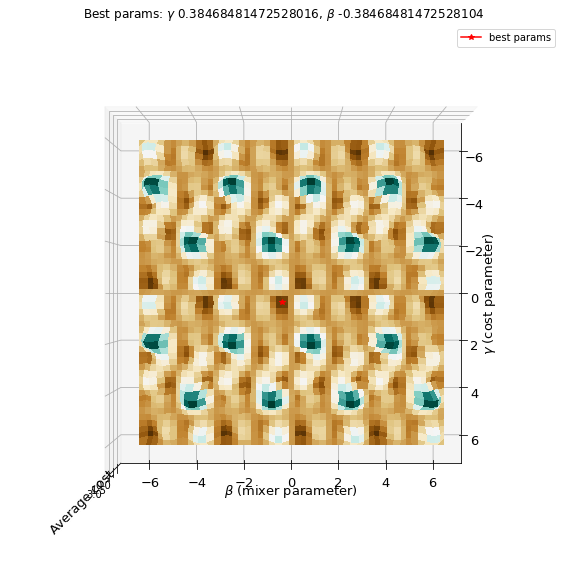

In [9]:
# Make a nice plot
def plot_energy_landscape(X, Y, Z, i, above = False):
    from matplotlib import cm
    from matplotlib.ticker import MaxNLocator
    name = 'Average cost'
    fig = plt.figure(np.random.randint(51, 60), figsize=(12, 8), constrained_layout=True)
    ax = fig.add_subplot(projection="3d")
    xx, yy = np.meshgrid(X, Y, indexing='ij')
    surf = ax.plot_surface(xx, yy, Z, cmap=cm.BrBG, antialiased=False)
    ax.set_xlabel(r"$\gamma$ (cost parameter)", fontsize=13)
    ax.set_ylabel(r"$\beta$ (mixer parameter)", fontsize=13)
    ax.set_zlabel(name, fontsize=13)
    ax.zaxis.set_label_coords(-1,1)
    ax.zaxis.set_major_locator(MaxNLocator(nbins=5, prune="lower"))
    ax.plot(X[i[0]], Y[i[1]], Z[i], c="red", marker="*", label="best params", zorder=10)
    plt.legend()
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title(r'Best params: $\gamma$ ' + str(X[i[0]]) + r', $\beta$ ' + str(Y[i[1]]))
    if above:
        ax.view_init(azim=0, elev=90)

plot_energy_landscape(X, Y, Z, i, above = True)

In [10]:
# The best parameters after the gris search
best_params_grid_search = np.array([[X[i[0]]], [Y[i[1]]]])
print('Best parameters from grid search:\n', best_params_grid_search)
print()
print('Average cost for the best parameters:\n', average_cost(best_params_grid_search))


Best parameters from grid search:
 [[ 0.38468481]
 [-0.38468481]]

Average cost for the best parameters:
 -1.397348126900863


<BarContainer object of 16 artists>

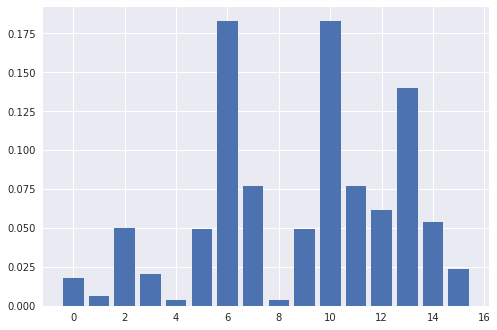

In [11]:
# What does the numbers mean? We want answers to the Minimum vertex cover

# Probability of measuring the different answers
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params_grid_search)
plt.style.use("seaborn")
plt.bar(range(2 ** len(qubits)), probs)

State 6 = 0110 and 10 = 1010 have the highest probability of beaing measured. Which are the best ones!

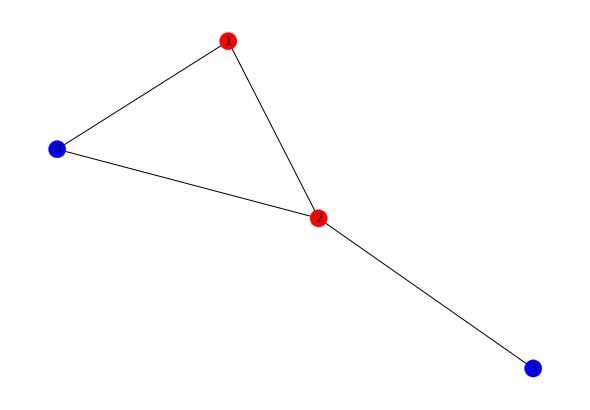

In [18]:
color_map_6 = ['red', 'blue', 'red', 'blue']
color_map_10 = ['blue', 'red', 'red', 'blue']

#nx.draw(graph, node_color=color_map_6, with_labels=True)
nx.draw(graph, node_color=color_map_10, with_labels=True)

# They are mirrored!

## Optimisation
Grid search is hard when p is above 2. The higher the p the better (kinda)).

We could do it with a smarter algorithm, let's borrow some from Machine learning: gradient descent!

In [13]:
optimiser = qml.GradientDescentOptimizer()
steps = 100
#initial_params = np.array([[0.5], [0.5]], requires_grad = True)
#p = 1
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
p = 2

params = initial_params

for i in range(steps):
    params = optimiser.step(average_cost, params)
    
best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

Optimal parameters:
 [[0.59805356 0.94199357]
 [0.52797309 0.85553493]]
Average cost for the best parameters:
 -1.5720009432822595


In [14]:
# What did we do? Let's plot it! A walk in the energy landscape.

# We want to save more info
cost_vector = np.zeros(steps)
cost_vector[0] = average_cost(initial_params)
params_vector = np.zeros((steps, 2, p))

params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(average_cost, params)
    cost_vector[i] = cost_

best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

Optimal parameters:
 [[0.59805356 0.94199357]
 [0.52797309 0.85553493]]
Average cost for the best parameters:
 -1.5720009432822595


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

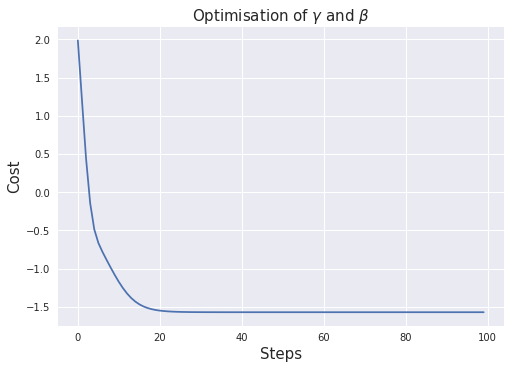

In [15]:
plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

<BarContainer object of 16 artists>

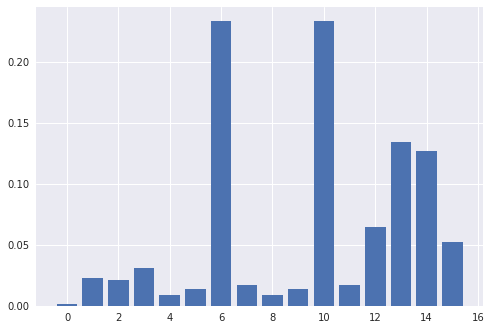

In [16]:
probs = probability_circuit(best_params_optimisation)
plt.style.use("seaborn")
plt.bar(range(2 ** len(qubits)), probs)

# we won't get 6 and 10 if p=1, we need p=2 (given this optimiser and hyperparameters).

## Optimisation function
What if we had another function to optimise over?
